In [ ]:
from google.colab import drive
import os
import sys
import shutil
import subprocess

drive.mount('/content/drive')

# Project paths
PROJECT_PATH = '/content/drive/MyDrive/SVGEditor'
CODE_PATH = f"{PROJECT_PATH}/code"
MODEL_PATH = f"{PROJECT_PATH}/models/qwen-image-edit"
OUTPUT_PATH = f"{PROJECT_PATH}/output"

if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)

# Target configuration
TARGET_NAME = "153_B"
TARGET_OUTPUT_PATH = f"{OUTPUT_PATH}/{TARGET_NAME}"

# Input image path (from project resource folder)
INPUT_IMAGE = f"{CODE_PATH}/resource/{TARGET_NAME}.png"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# Install dependencies
%pip install diffusers accelerate safetensors transformers huggingface_hub segment-anything opencv-python pillow matplotlib scikit-image scikit-learn cairosvg moviepy shapely networkx lxml skan rdp

import shutil
import subprocess

# Clean and clone repository
if os.path.exists(CODE_PATH):
    shutil.rmtree(CODE_PATH)

os.chdir(PROJECT_PATH)
result = subprocess.run(['git', 'clone', 'https://github.com/huanbasara/SVGEditor.git', 'code'],
                       capture_output=True, text=True)
print(f"Repository {'successfully' if result.returncode == 0 else 'failed'} cloned")

# Display latest commit info
os.chdir(CODE_PATH)
commit_info = subprocess.run(['git', 'log', '-1', '--pretty=format:%ci|%s'],
                           capture_output=True, text=True)

if commit_info.returncode == 0:
    commit_time, commit_msg = commit_info.stdout.strip().split('|', 1)
    print(f"Latest commit: {commit_time.split()[0]} - {commit_msg}")

# Add to Python path and reload modules
if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)

# Clear custom modules from cache
for base in ['sam_processor', 'svglib', 'utils']:
    to_remove = [m for m in sys.modules if m.startswith(base)]
    for m in to_remove:
        del sys.modules[m]

# Create necessary directories
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(TARGET_OUTPUT_PATH, exist_ok=True)

print("Setup complete!")

Repository successfully cloned
Latest commit: 2025-10-03 - opt uniform_line_thickness
Setup complete!


Clearing GPU memory...
Loading model...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Model loaded with CPU offload
Edit prompt: Transform this girl's long ponytail into a chic, shoulder-length layered cut. Remove all long flowing hair. Ensure clean, continuous lines without artifacts. Maintain the exact same minimalist black line art style on pure white background. Convert all lines to uniform deep black color with consistent thickness. Keep all unmodified parts with their original line structure, position, and curvature. Ensure all lines are clear, smooth, and of the same color depth and weight. Avoid any variations in line weight or opacity within the new image.
Negative prompt: inconsistent line thickness, varying line weight, gradient lines, non-uniform line opacity, thick and thin lines mixed, uneven line density, color variations in lines, non-black lines, colored lines, gradient effects, white background noise, speckles, dots, artifacts, jagged edges, broken lines, discontinuous lines, blurry lines, low quality, distorted, messy


  0%|          | 0/30 [00:00<?, ?it/s]

Edited image saved: /content/drive/MyDrive/SVGEditor/output/153_B/1.153_B_qwen_edit.png


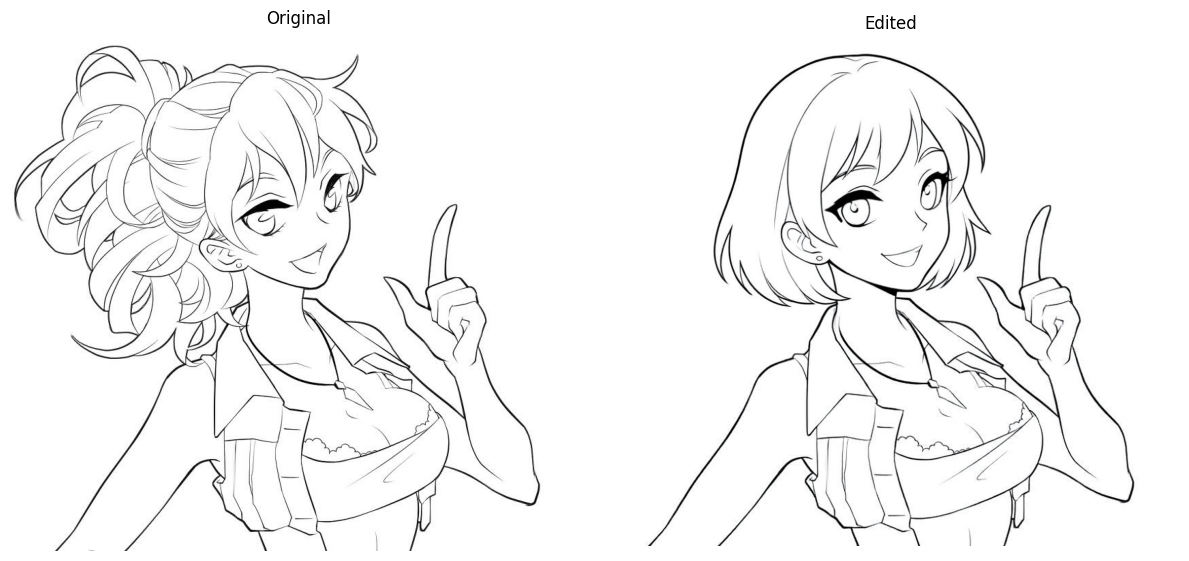

In [ ]:
# Image Editing with Qwen

import torch
import gc
from PIL import Image
from diffusers import QwenImageEditPipeline
from utils.prompt_utils import get_prompt, get_negative_prompt
from utils.plot_utils import plot_images

def load_qwen_model():
    """Load Qwen image editing model"""
    print("Clearing GPU memory...")
    torch.cuda.empty_cache()
    gc.collect()

    print("Loading model...")
    pipeline = QwenImageEditPipeline.from_pretrained(
        MODEL_PATH,
        local_files_only=True,
        torch_dtype=torch.bfloat16
    )
    pipeline.set_progress_bar_config(disable=None)
    pipeline.enable_model_cpu_offload()
    print("✅ Model loaded with CPU offload")
    return pipeline

def process_image_with_qwen(pipeline, image, prompt, negative_prompt):
    """Process image with Qwen model"""
    inputs = {
        "image": image,
        "prompt": prompt,
        "generator": torch.manual_seed(0),
        "true_cfg_scale": 4.0,
        "negative_prompt": negative_prompt,
        "num_inference_steps": 30,
    }

    with torch.inference_mode():
        output = pipeline(**inputs)
        output_image = output.images[0]

    # Save edited image
    output_path = f"{TARGET_OUTPUT_PATH}/{TARGET_NAME}_qwen_edit.png"
    output_image.save(output_path)
    print(f"Edited image saved: {output_path}")

    return output_image

# Execute image editing
pipeline = load_qwen_model()
original_image = Image.open(INPUT_IMAGE)
edit_prompt = get_prompt(TARGET_NAME)
negative_prompt = get_negative_prompt()
print(f"Edit prompt: {edit_prompt}")
print(f"Negative prompt: {negative_prompt}")

edited_image = process_image_with_qwen(pipeline, original_image, edit_prompt, negative_prompt)

plot_images([(original_image, "Original"), (edited_image, "Edited")])

In [ ]:
# Cleanup
del pipeline
torch.cuda.empty_cache()
gc.collect()
print("Processing completed")

Processing completed


IMAGE PREPROCESSING PIPELINE
Parameters:
  - Binary threshold: 180
  - Morphological smoothing: kernel=3, iterations=1
  - Line thickness: target=3px, preserve=0.5
Loading image: /content/drive/MyDrive/SVGEditor/output/153_B/153_B_qwen_edit.png
Original image shape: (960, 1088)

Binarization: threshold=180
White pixels: 47516

STEP 1: Morphological Smoothing (Closing Operation)
Morphological smoothing: kernel=3x3, iterations=1
White pixels: 47516 → 48287

STEP 2: Fill-to-Outline Conversion
Processed 3 thick filled regions

STEP 3: Uniform Line Thickness
Uniform line thickness: target_width=3px, preserve_threshold=0.5
Preserved 25 thin lines, rebuilt 6 thick lines
White pixels: 46976 → 70734

Saving intermediate files...
✅ All files saved to: /content/drive/MyDrive/SVGEditor/output/153_B

✅ PREPROCESSING COMPLETED!


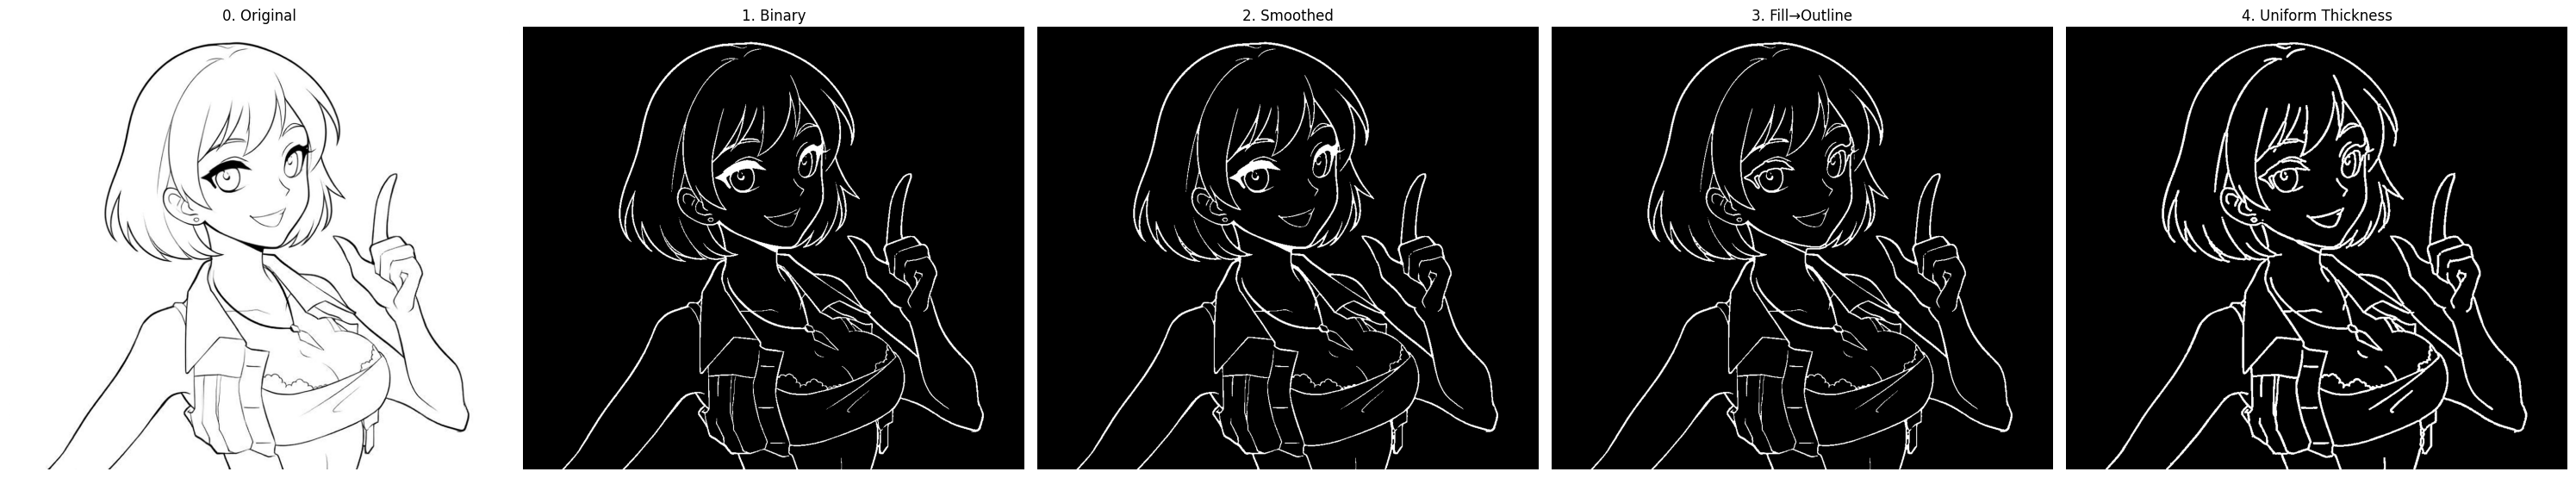


Next step: Skeleton extraction for SVG path generation


In [46]:
# Fill-to-Outline Processing with Visualization

import cv2
import numpy as np
from PIL import Image
import os
from utils.plot_utils import plot_images
from utils.image_utils import morphological_smooth, uniform_line_thickness

# Processing parameters
BINARY_THRESHOLD = 180
THICKNESS_THRESHOLD = 5
MIN_FILL_AREA = 300
OUTLINE_WIDTH = 2

# Step 1: Morphological smoothing (closing operation)
MORPH_KERNEL_SIZE = 3  # Kernel size (3, 5, 7)
MORPH_ITERATIONS = 1   # Iterations (1-2 recommended)

# Step 3: Line thickness uniformization
TARGET_WIDTH = 3           # Target line width in pixels (3-5 recommended)
PRESERVE_THRESHOLD = 0.5   # Preserve lines thinner than target_width * 0.5


def convert_fills_to_outlines(binary_img):
    """Convert thick filled regions to outline borders"""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (THICKNESS_THRESHOLD, THICKNESS_THRESHOLD))
    eroded = cv2.erode(binary_img, kernel)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded)

    result_img = binary_img.copy()
    processed_count = 0

    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]
        if area < MIN_FILL_AREA:
            continue

        component_mask = (labels == i).astype(np.uint8) * 255
        dilated_mask = cv2.dilate(component_mask, kernel)
        original_fill = cv2.bitwise_and(binary_img, dilated_mask)
        outline_mask = create_outline_from_fill(original_fill)

        result_img = cv2.bitwise_and(result_img, cv2.bitwise_not(dilated_mask))
        result_img = cv2.bitwise_or(result_img, outline_mask)
        processed_count += 1

    print(f"Processed {processed_count} thick filled regions")
    return result_img


def create_outline_from_fill(fill_mask):
    """Generate outline from fill region"""
    contours, _ = cv2.findContours(fill_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    outline_mask = np.zeros_like(fill_mask)
    for contour in contours:
        cv2.drawContours(outline_mask, [contour], -1, 255, thickness=OUTLINE_WIDTH)
    return outline_mask


def process_image_preprocessing():
    """
    3-step image preprocessing:
    Step 1: Morphological smoothing (connect breaks, smooth contours)
    Step 2: Fill-to-outline conversion (remove filled regions)
    Step 3: Uniform line thickness (skeleton-based reconstruction)
    """
    input_path = os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_qwen_edit.png")

    if not os.path.exists(input_path):
        print(f"ERROR: Input file not found: {input_path}")
        return None

    print(f"Loading image: {input_path}")
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    print(f"Original image shape: {img.shape}")

    # Initial binarization
    _, binary = cv2.threshold(img, BINARY_THRESHOLD, 255, cv2.THRESH_BINARY_INV)
    print(f"\nBinarization: threshold={BINARY_THRESHOLD}")
    print(f"White pixels: {np.sum(binary > 0)}")

    # Save intermediate results
    results = {
        'original': img,
        'binary': binary
    }

    # Step 1: Morphological smoothing
    print(f"\n{'='*60}")
    print("STEP 1: Morphological Smoothing (Closing Operation)")
    print(f"{'='*60}")
    step1_result = morphological_smooth(
        binary,
        kernel_size=MORPH_KERNEL_SIZE,
        iterations=MORPH_ITERATIONS
    )
    results['step1_smoothed'] = step1_result

    # Step 2: Fill-to-outline conversion
    print(f"\n{'='*60}")
    print("STEP 2: Fill-to-Outline Conversion")
    print(f"{'='*60}")
    step2_result = convert_fills_to_outlines(step1_result)
    results['step2_outline'] = step2_result

    # Step 3: Uniform line thickness
    print(f"\n{'='*60}")
    print("STEP 3: Uniform Line Thickness")
    print(f"{'='*60}")
    step3_result = uniform_line_thickness(
        step2_result,
        target_width=TARGET_WIDTH,
        preserve_threshold=PRESERVE_THRESHOLD
    )
    results['step3_uniform'] = step3_result

    # Save all intermediate files
    print(f"\n{'='*60}")
    print("Saving intermediate files...")
    print(f"{'='*60}")

    cv2.imwrite(os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_0_original.png"), img)
    cv2.imwrite(os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_1_binary.png"), binary)
    cv2.imwrite(os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_2_smoothed.png"), step1_result)
    cv2.imwrite(os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_3_outline.png"), step2_result)
    cv2.imwrite(os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_4_uniform.png"), step3_result)

    print(f"✅ All files saved to: {TARGET_OUTPUT_PATH}")

    return results


# Execute preprocessing
print("="*60)
print("IMAGE PREPROCESSING PIPELINE")
print("="*60)
print(f"Parameters:")
print(f"  - Binary threshold: {BINARY_THRESHOLD}")
print(f"  - Morphological smoothing: kernel={MORPH_KERNEL_SIZE}, iterations={MORPH_ITERATIONS}")
print(f"  - Line thickness: target={TARGET_WIDTH}px, preserve={PRESERVE_THRESHOLD}")
print("="*60)

results = process_image_preprocessing()

if results is not None:
    print(f"\n{'='*60}")
    print("✅ PREPROCESSING COMPLETED!")
    print(f"{'='*60}")

    # Visualize all steps
    images_to_plot = [
        (Image.fromarray(results['original']).convert('RGB'), "0. Original"),
        (Image.fromarray(results['binary']).convert('RGB'), "1. Binary"),
        (Image.fromarray(results['step1_smoothed']).convert('RGB'), "2. Smoothed"),
        (Image.fromarray(results['step2_outline']).convert('RGB'), "3. Fill→Outline"),
        (Image.fromarray(results['step3_uniform']).convert('RGB'), "4. Uniform Thickness")
    ]

    plot_images(images_to_plot)

    print("\nNext step: Skeleton extraction for SVG path generation")
else:
    print("\n❌ PREPROCESSING FAILED!")